# DL-Ops Assignment 2: Build a Seq2SeqLSTM Model

## Checking Avilable GPU

In [1]:
!nvidia-smi

Thu Apr  6 23:36:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   52C    P8    43W / 350W |    484MiB / 24576MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing requirements

In [2]:
# pytorch libs
import torch
from torch import nn
import torchvision

# matplot libs
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch metrics
try:
  import torchmetrics
except:
  !pip3 -q install torchmetrics
import torchmetrics
from torchmetrics.classification import Accuracy

try:
  import torchinfo 
except:
  !pip3 -q install torchinfo
finally:
  from torchinfo import summary

try:
  import torchtext as tt
except:
  !pip -q install torchtext
finally:
  import torchtext as tt
  
from pandarallel import pandarallel
# Initialization
pandarallel.initialize()


#string manupulation libs
import re
import string
from string import digits
import spacy

#torch libs
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

/home/planck/anaconda3/envs/bikash/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Process the data

In [4]:
### read data
import pandas as pd
dataset_train = pd.read_csv("data/Dakshina Dataset/hi/lexicons/hi.translit.sampled.train.tsv", sep='\t', names=["hindi", "english","nums"])

In [5]:
### read data
import pandas as pd
dataset_test = pd.read_csv("data/Dakshina Dataset/hi/lexicons/hi.translit.sampled.test.tsv", sep='\t', names=["hindi", "english","nums"],index_col=False)

In [6]:
dataset_train.head()

,hindi,english,nums
0,अं,an,3
1,अंकगणित,ankganit,3
2,अंकल,uncle,4
3,अंकुर,ankur,4
4,अंकुरण,ankuran,3


In [7]:
dataset_train.dropna(inplace=True)
dataset_test.dropna(inplace=True)

In [8]:
dataset_test.head()

,hindi,english,nums
0,अंक,ank,5
1,अंक,anka,1
2,अंकित,ankit,3
3,अंकों,anakon,1
4,अंकों,ankhon,1


## Defining Custom Dataset Class

In [9]:
import os
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Vocabulary:
    def __init__(self, freq_threshold, max_size):
        #defining pad, start of sentence, end of sentence and unknown token index
        self.itos = {0:"<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"} #index to string dict
        self.stoi = {k:j for j,k in self.itos.items()} #string to index dict
        self.freq_threshold = freq_threshold #minimum word frequency needed to be included in vocab
        self.max_size = max_size #max vocab size
        
    def __len__(self):
        return len(self.itos)
    
    
    
    '''
    a simple tokenizer that splits on space and converts the sentence to list of words 
    '''
    @staticmethod #static method is independent of a class instance
    def tokenizer(text):
        try:
            return [tok.lower().strip() for tok in text.split(' ')]
        except:
            print(text)
            exit(1)
    
    '''
    build the vocab
    '''
    def build_vocabulary(self,sentence_list):
        frequencies = {}
        idx = 4
        
        #calculate freq of words
        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                if word not in frequencies.keys():
                    frequencies[word]=1
                else:
                    frequencies[word]+=1
        
        #limit vocab by removing low freq words
        frequencies = {k:v for k,v in frequencies.items() if v>self.freq_threshold}
        #limit vocab to the max size specified
        if len(frequencies)>self.max_size-4:
            frequencies = dict(sorted(frequencies.items(), key = lambda x: -x[1])[:self.max_size-4]) #-4 for start,end, pad, unk token
        #create vocab
        for word in frequencies.keys():
            self.stoi[word] = idx
            self.itos[idx] = word
            idx+=1
                
    '''
    convert the list of words to a list of corresponding indexes
    '''
    def numericalize(self, text):
        tokenized_text = self.tokenizer(text)
        numericalized_text = []
        for token in tokenized_text:
            if token in self.stoi.keys():
                numericalized_text.append(self.stoi[token])
            else:
                numericalized_text.append(self.stoi['<UNK>'])
        
        return numericalized_text
                    

class Train_Dataset(Dataset): 
    
    '''
    Initiating Variables
    source_column : the name of source text column in the dataframe
    target_columns : the name of target text column in the dataframe
    transform : If we want to add any augmentation
    freq_threshold : the minimum times a word must occur in corpus to be treated in vocab
    source_vocab_max_size : max source vocab size
    target_vocab_max_size : max target vocab size
    '''
    def __init__(self, df,source_column, target_column, transform = None, freq_threshold = 0, 
                 source_vocab_max_size= 10000, target_vocab_max_size = 10000):
        self.df = df
        self.transform = transform
        
        #get source and target texts
        self.source_texts = self.df[source_column].values
        self.target_texts = self.df[target_column].values
        # print(self.source_texts)
        # print(self.target_texts)
        
        ##VOCABULARY class will be created below
        #create source vocab
        self.source_vocab = Vocabulary(freq_threshold,source_vocab_max_size)
        self.source_vocab.build_vocabulary(self.source_texts.tolist())
        #create target vocab
        self.target_vocab = Vocabulary(freq_threshold,target_vocab_max_size)
        self.target_vocab.build_vocabulary(self.target_texts.tolist())
        
        
        
    def __len__(self):
        return len(self.df)
    
    #getitem gets 1 example at a time. This is done before a batch is created
    def __getitem__(self, index):
        # print(index)
        # print(self.source_texts[index])
        source_text = self.source_texts[index]
        # print(source_text)
        target_text = self.target_texts[index]
        # print(target_text)
        if self.transform is not None:
            source_text = self.transform(source_text)
            
        #numericalize texts ['<SOS>','cat', 'in', 'a', 'bag','<EOS>'] -> [1,12,2,9,24,2]
        numerialized_source = [self.source_vocab.stoi["<SOS>"]]
        numerialized_source += self.source_vocab.numericalize(source_text)
        numerialized_source.append(self.source_vocab.stoi["<EOS>"])
    
        numerialized_target = [self.target_vocab.stoi["<SOS>"]]
        numerialized_target += self.target_vocab.numericalize(target_text)
        numerialized_target.append(self.target_vocab.stoi["<EOS>"])
        #print(numerialized_source)
        return torch.tensor(numerialized_source), torch.tensor(numerialized_target) 
    

"""
Create a separate dataset for Test as we
are going to reuse train's vocabulary.
Better practice to define a separate class for Test
""" 

class Test_Dataset:
    def __init__(self, train_dataset, df, source_column, target_column, transform = None):
        self.df = df
        self.transform = transform
        
        #train dataset will be used as lookup for vocab
        self.train_dataset = train_dataset
        
        #get source and target texts
        self.source_texts = self.df[source_column].values
        self.target_texts = self.df[target_column].values
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        source_text = self.source_texts[index]
        #print(source_text)
        target_text = self.target_texts[index]
        #print(target_text)
        if self.transform is not None:
            source_text = self.transform(source_text)
            
        #numericalize texts ['<SOS>','cat', 'in', 'a', 'bag','<EOS>'] -> [1,12,2,9,24,2]
        numerialized_source = [self.train_dataset.source_vocab.stoi["<SOS>"]]
        numerialized_source += self.train_dataset.source_vocab.numericalize(source_text)
        numerialized_source.append(self.train_dataset.source_vocab.stoi["<EOS>"])
    
        numerialized_target = [self.train_dataset.target_vocab.stoi["<SOS>"]]
        numerialized_target += self.train_dataset.target_vocab.numericalize(target_text)
        numerialized_target.append(self.train_dataset.target_vocab.stoi["<EOS>"])
        #print(numerialized_source)
        return torch.tensor(numerialized_source), torch.tensor(numerialized_target) 



"""
a class to create padding to the batches
 collat_fn in dataloader is used for postprocessing on a single batch. Like __getitem__ in dataset class was used
 for a single example
"""

class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
        
    # __call__ :
    ##    First the obj is created using MyCollate(pad_idx).
    ##    Then if obj(batch) is called -> __call__ runs by default
    def __call__(self, batch):
        source = [item[0] for item in batch]
        source = pad_sequence(source, batch_first=False, padding_value = self.pad_idx)
        target = [item[1] for item in batch]
        target = pad_sequence(target, batch_first=False, padding_value = self.pad_idx)
        
        return source,target


# If we run a next(iter(data_loader)) we get an output of batch_size * (num_workers+1)
def get_train_loader(dataset, batch_size, num_workers=1, shuffle=True, pin_memory=False):
    pad_idx = dataset.source_vocab.stoi['<PAD>']
    loader = DataLoader(dataset, batch_size = batch_size, num_workers = num_workers,
                        shuffle=shuffle,
                       pin_memory=pin_memory, collate_fn = MyCollate(pad_idx=pad_idx))
    return loader

def get_valid_loader(dataset, train_dataset, batch_size, num_workers=1, shuffle=True, pin_memory=False):
    pad_idx = train_dataset.source_vocab.stoi['<PAD>']
    loader = DataLoader(dataset, batch_size = batch_size, num_workers = num_workers,
                        shuffle=shuffle,
                       pin_memory=pin_memory, collate_fn = MyCollate(pad_idx=pad_idx))
    return loader

In [10]:
#create a vocab class with freq_threshold=0 and max_size=100
voc = Vocabulary(0, 100)
sentence_list = ['anakon', 'ankit']
#build vocab
voc.build_vocabulary(sentence_list)

print('index to string: ',voc.itos)
print('string to index:',voc.stoi)

print('numericalize -> cat and a dog: ', voc.numericalize('cat and a dog'))

index to string:  {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'anakon', 5: 'ankit'}
string to index: {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'anakon': 4, 'ankit': 5}
numericalize -> cat and a dog:  [3, 3, 3, 3]


In [11]:
train_df = dataset_train[["hindi","english"]]
train_df.head()

,hindi,english
0,अं,an
1,अंकगणित,ankganit
2,अंकल,uncle
3,अंकुर,ankur
4,अंकुरण,ankuran


In [12]:
train_dataset = Train_Dataset(dataset_train, source_column = "english", target_column = "hindi", transform = None)
print(f"length of train dataset: {len(train_dataset)}")

length of train dataset: 44202


In [13]:
test_df = dataset_test[["hindi","english"]]
test_df.head()

,hindi,english
0,अंक,ank
1,अंक,anka
2,अंकित,ankit
3,अंकों,anakon
4,अंकों,ankhon


In [14]:
test_dataset = Test_Dataset(train_dataset, dataset_test, source_column = "english", target_column = "hindi", transform = None)
print(f"length of test dataset: {len(test_dataset)}")

length of test dataset: 4502


## Defining Model

### Model SEQ2SEQ RNN

In [15]:
import random
class EncoderRNN(nn.Module):
    """
    ### Define EncoderRNN
    The input to encoder is the whole sentence. Therefore, the size of x in forward is (seq_length, batch_size)
    """
    '''
    input_size -> source vocab size
    '''
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout_p):
        super(EncoderRNN, self).__init__()
        self.dropout = nn.Dropout(dropout_p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, dropout=dropout_p)
        
    def forward(self, x):
        # print("Inside encoder forward")
        # shape of x-> (seq_length, batch_size)
        embedding = self.dropout(self.embedding(x)) #shape-> (seq_length, batch_size, embedding_size)
        # print(f"embedding shape: {embedding.shape}")
        outputs, (hidden,cell) = self.rnn(embedding)
        # print('output: ', outputs.shape, '\nhidden: ', hidden.shape)
        return hidden, cell #shape-> (num_layers, batch_size, hidden_size)





class DecoderRNN(nn.Module):
    """
    ### Define DecoderRNN
    * Input is one word at a time. shape of x is-> (1, batch_size)
    * embedding size-> (1, batch_size, embedding_size)
    * outputs-> (1, batch_size, hidden_size)
    * predictions -> (batch_size, output_size)
    """
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, dropout_p):
        super(DecoderRNN, self).__init__()
        self.dropout = nn.Dropout(dropout_p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, dropout = dropout_p)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden, cell):
        # print("Inside decoder forward")
        # for next(iter(train_loader))[1][0] will give us the first word for batch_size (,batch_size)
        # to input to model, we need to add a dimension at 0
        # x-> (, batch_size) -> convert to (1, batch_size)
        x = x.unsqueeze(0)
        #print('input unsqueezed: ', x.shape)
        embedding = self.dropout(self.embedding(x)) #(1, batch_size, embedding_size)
        #print('embedding: ', embedding.shape)
        # print(f"embedding shape: {embedding.shape}")
        # print(f"hidden shape: {hidden.shape}")
        # print(f"c shape: {cell.shape}")
        output, (hidden, cell) = self.rnn(embedding,torch.stack([hidden, cell])) #UG-> Need to understand how RNN takes both inputs
        # print('output: ', output.shape, '\nhidden: ', hidden.shape)
        #outputshape -> (1, batch_size, hidden_size)
        predictions = self.fc(output) #(1, batch_size, output_size)
        #print('predictions: ', predictions.shape)
        #to send predictions to loss func we need to remove 0th dim
        predictions = predictions.squeeze(0)
        #print('predictions squeezed: ', predictions.shape)
        return predictions, hidden, cell
        

class Seq2SeqRNN(nn.Module):
    def __init__(self, encoder, decoder, output_size, device):
        super(Seq2SeqRNN, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.output_size = output_size
        self.device = device
        
    def forward(self, source , target, teacher_force_ratio = 0.5):
        #source-> (max_seq_length, batch_size)
        #target-> (max_seq_length, batch_size)
        batch_size = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = self.output_size #the size of target vocab
        
        #this tensor will be used for predicting output one by one
        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)
        
        hidden, cell = self.encoder(source)
        
        #get first token from input to the decoder -> <SOS>
        x = target[0] #shape -> (,batch_size)
        
        for t in range(1, target_len):
            #get output, hidden, cell from decoder. Input is x, previous hidden and cell
            prediction, hidden, cell = self.decoder(x, hidden, cell)
            #prediction shape-> (batch_size, target_vocab_size)
            
            #store next output prediction
            outputs[t] = prediction
            
            #get best word the decoder predicted (index of target_vocab)
            best_guess = prediction.argmax(1)
            #print('best guess: ', best_guess.shape)
            #print('target[t]: ', target[t].shape)
            # teacher forcing ratio is used to sometime input the previous prediction and sometime give the actual word from training data
            x = target[t] if random.random()<teacher_force_ratio else best_guess
            
            
        return outputs #shape-> (seq_length, batch_size, target_vocab)

### Model SEQ2SEQ LSTM

In [16]:
import random

class EncoderLSTM(nn.Module):
    """
    ### Define EncoderLSTM
    The input to encoder is the whole sentence. Therefore, the size of x in forward is (seq_length, batch_size)
    """
    '''
    input_size -> source vocab size
    '''
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout_p):
        super(EncoderLSTM, self).__init__()
        self.dropout = nn.Dropout(dropout_p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout_p)
        
    def forward(self, x):
        # shape of x-> (seq_length, batch_size)
        embedding = self.dropout(self.embedding(x)) #shape-> (seq_length, batch_size, embedding_size)
        
        outputs, (hidden,cell) = self.rnn(embedding)
        
        return hidden, cell #shape-> (num_layers, batch_size, hidden_size)





class DecoderLSTM(nn.Module):
    """
    ### Define DecoderLSTM
    * Input is one word at a time. shape of x is-> (1, batch_size)
    * embedding size-> (1, batch_size, embedding_size)
    * outputs-> (1, batch_size, hidden_size)
    * predictions -> (batch_size, output_size)
    """
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, dropout_p):
        super(DecoderLSTM, self).__init__()
        self.dropout = nn.Dropout(dropout_p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout = dropout_p)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden, cell):
        # for next(iter(train_loader))[1][0] will give us the first word for batch_size (,batch_size)
        # to input to model, we need to add a dimension at 0
        # x-> (, batch_size) -> convert to (1, batch_size)
        x = x.unsqueeze(0)
        #print('input unsqueezed: ', x.shape)
        embedding = self.dropout(self.embedding(x)) #(1, batch_size, embedding_size)
        #print('embedding: ', embedding.shape)
        output, (hidden, cell) = self.rnn(embedding, (hidden, cell)) #UG-> Need to understand how LSTM takes both inputs
        #print('output: ', output.shape, '\nhidden: ', hidden.shape)
        #outputshape -> (1, batch_size, hidden_size)
        predictions = self.fc(output) #(1, batch_size, output_size)
        #print('predictions: ', predictions.shape)
        #to send predictions to loss func we need to remove 0th dim
        predictions = predictions.squeeze(0)
        #print('predictions squeezed: ', predictions.shape)
        return predictions, hidden, cell
        

class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder, output_size, device):
        super(Seq2SeqLSTM, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.output_size = output_size
        self.device = device
        
    def forward(self, source , target, teacher_force_ratio = 0.5):
        #source-> (max_seq_length, batch_size)
        #target-> (max_seq_length, batch_size)
        batch_size = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = self.output_size #the size of target vocab
        
        #this tensor will be used for predicting output one by one
        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)
        
        hidden, cell = self.encoder(source)
        
        #get first token from input to the decoder -> <SOS>
        x = target[0] #shape -> (,batch_size)
        
        for t in range(1, target_len):
            #get output, hidden, cell from decoder. Input is x, previous hidden and cell
            prediction, hidden, cell = self.decoder(x, hidden, cell)
            #prediction shape-> (batch_size, target_vocab_size)
            
            #store next output prediction
            outputs[t] = prediction
            
            #get best word the decoder predicted (index of target_vocab)
            best_guess = prediction.argmax(1)
            #print('best guess: ', best_guess.shape)
            #print('target[t]: ', target[t].shape)
            # teacher forcing ratio is used to sometime input the previous prediction and sometime give the actual word from training data
            x = target[t] if random.random()<teacher_force_ratio else best_guess
            
            
        return outputs #shape-> (seq_length, batch_size, target_vocab)

## Initialize network

In [17]:
# Training hyperparameters
num_epochs = 15
learning_rate = 0.001
batch_size = 128

# Model hyperparameters
input_size_encoder = 10000
input_size_decoder = 10000
output_size = input_size_decoder #compulsory to define
encoder_embedding_size = 150
decoder_embedding_size = 150
hidden_size = 1024  # Needs to be the same for both RNN's
num_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5

# Tensorboard to get nice loss plot
#writer = SummaryWriter(f"runs/loss_plot")

transforms = False

train_loader = get_train_loader(train_dataset, batch_size, num_workers=4, shuffle=True, pin_memory=True)
test_loader = get_valid_loader(test_dataset, train_dataset, batch_size, num_workers=4, shuffle=True, pin_memory=True)

In [18]:
# define models, 1 for RNN and 2 for LSTM seq2seq
encoder_net_rnn = EncoderRNN(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net_rnn = DecoderRNN(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)

model_rnn = Seq2SeqRNN(encoder_net_rnn, decoder_net_rnn, output_size, device)
model_rnn.to(device)

encoder_net_lstm = EncoderLSTM(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net_lstm = DecoderLSTM(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)

model_lstm = Seq2SeqLSTM(encoder_net_lstm, decoder_net_lstm, output_size, device)
model_lstm.to(device)

Seq2SeqLSTM(
  (encoder): EncoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(10000, 150)
    (rnn): LSTM(150, 1024, num_layers=2, dropout=0.5)
  )
  (decoder): DecoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(10000, 150)
    (rnn): LSTM(150, 1024, num_layers=2, dropout=0.5)
    (fc): Linear(in_features=1024, out_features=10000, bias=True)
  )
)

## Utill functios

### plotting training testing & train loop functions

In [19]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """
    Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {
              "train_loss": [...],
              "test_loss": [...],
             }
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(7, 7))

    # Plot loss
    plt.subplot(1, 1, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    

def training_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str,
):
    """
    Desc:
      funtion to perform traning step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      optimizer (torch.optim.Optimizer): Optimizer Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
    Returns:
      train_loss (float), train_acc (float): training loss and training accuracy for one EPOCH
    """
    model.train()  # putting model in traing model

    train_loss = 0  # initlizing loss and acc. for the epoch

    # print(type(model.parameters()))
    for (X, y) in dataloader:  # loop in batches
        # model_parms_before_forward_pass = np.array([x.detach().numpy() for x in model.parameters()].copy())
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")
        
        # 1. forward pass
        y_pred_logits = model(X,y)
        
        y_pred_logits = y_pred_logits[1:].reshape(-1, y_pred_logits.shape[2])
        y = y[1:].reshape(-1)
        
        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backword
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # model_parms_after_forward_pass = np.array([x.detach().numpy() for x in model.parameters()])
        # print("Model parms diff:")
        # print([(i,j) for (i,j) in zip(iter(model_parms_after_forward_pass),iter(model_parms_before_forward_pass))])
        # print(model_parms_after_forward_pass - model_parms_before_forward_pass,sep="\n")
        # train_acc += acc_fn(y_pred_logits, y).item()

    # 6. returning actual loss and acc.x
    return train_loss / len(dataloader)#, train_acc / len(dataloader)



def testing_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    device: str,
):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      test_loss (float), test_acc (float): testing loss and testing accuracy for one EPOCH
    """
    model.eval()  # putting model in eval model

    test_loss = 0  # initlizing loss and acc. for the epoch

    # with torch.inference_mode(): # disabling inference mode for aqcuiring gradients of perturbed data
    for (X, y) in dataloader:  # loop in batches
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

        # 1. forward pass
        y_pred_logits = model(X,y)

        y_pred_logits = y_pred_logits[1:].reshape(-1, y_pred_logits.shape[2])
        y = y[1:].reshape(-1)
        
        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        test_loss += loss.item()

        # printing the prediction and actual label
        # print(y_pred_logits.argmax(dim=1), y,sep='\n')
        
        # 3. calculating accuracy
        # test_acc += acc_fn(y_pred_logits, y).item()

    # 6. returning actual loss and acc.
    return test_loss / len(dataloader)#, test_acc / len(dataloader)

from tqdm.auto import tqdm


def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: str,
):
    """
    Desc:
      funtion to perform training for one {epochs} param

    Args:
      model (nn.Module): Pytorch model class object
      train_dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      test_dataloader (torch.utils.data.DataLoader): testing dataloder from testing dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
      epochs (int): number of epochs to train the model
      device (str): Torch Device "CPU/GPU"
    Returns:
      result_dict ({str: List[float]}): testing loss and testing accuracy for one EPOCH
    """
    # 1. init. result dict
    result_dict = {"train_loss": [], "test_loss": []}

    # 2. loop in range epochs performs train and test steps on the model
    for epoch in tqdm(range(epochs)):
        train_loss = training_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            optimizer=optimizer,
            device=device,
        )

        test_loss = testing_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            device=device,
        )

        # 3. print out results
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"test_loss: {test_loss:.4f}  "
        )

        # 4. adding results to result_dict
        result_dict["train_loss"].append(train_loss)
        result_dict["test_loss"].append(test_loss)

    # 5. return result dict
    return result_dict

## Model Training RNN

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.8334 | test_loss: 0.3796  
Epoch: 2 | train_loss: 3.8023 | test_loss: 0.4447  
Epoch: 3 | train_loss: 3.8247 | test_loss: 0.4754  
Epoch: 4 | train_loss: 3.8281 | test_loss: 0.4933  
Epoch: 5 | train_loss: 3.8345 | test_loss: 0.4048  
Epoch: 6 | train_loss: 3.8366 | test_loss: 0.3335  
Epoch: 7 | train_loss: 3.8382 | test_loss: 0.2924  
Epoch: 8 | train_loss: 3.8397 | test_loss: 0.4989  
Epoch: 9 | train_loss: 3.8364 | test_loss: 0.4799  
Epoch: 10 | train_loss: 3.8398 | test_loss: 0.3127  
Epoch: 11 | train_loss: 3.8383 | test_loss: 0.4402  
Epoch: 12 | train_loss: 3.8434 | test_loss: 0.3836  
Epoch: 13 | train_loss: 3.8419 | test_loss: 0.4699  
Epoch: 14 | train_loss: 3.8377 | test_loss: 0.3421  
Epoch: 15 | train_loss: 3.8385 | test_loss: 0.3786  
total training time: 62.911 sec.


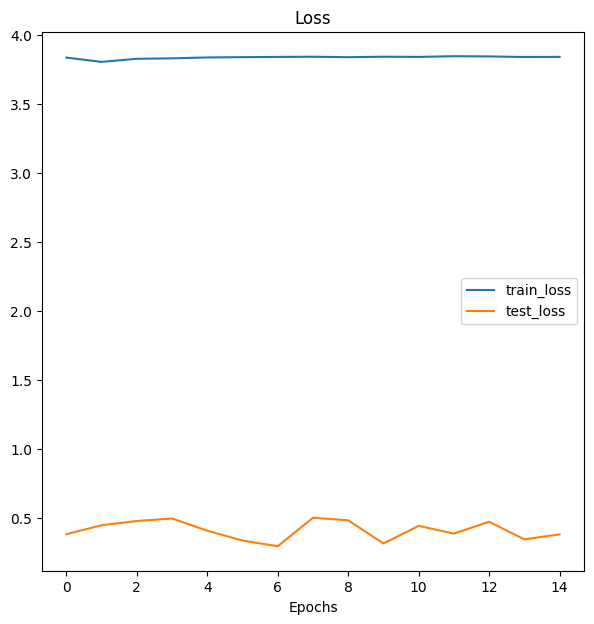

In [20]:
from timeit import default_timer as timer


optimizer = optim.Adam(model_rnn.parameters(), lr = learning_rate)

pad_idx = train_dataset.source_vocab.stoi['<PAD>']

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

accuracy = Accuracy("multiclass", num_classes=10000).to(device)

start_time = timer()

# train model_rnn
model_rnn_results = train(
    model=model_rnn,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    acc_fn=accuracy,
    epochs=num_epochs,
    device=device
)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
plot_loss_curves(model_rnn_results)


## Model Training LSTM

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.2618 | test_loss: 0.3787  
Epoch: 2 | train_loss: 2.9926 | test_loss: 0.4068  
Epoch: 3 | train_loss: 2.9192 | test_loss: 0.4034  
Epoch: 4 | train_loss: 2.8754 | test_loss: 0.4066  
Epoch: 5 | train_loss: 2.8526 | test_loss: 0.3787  
Epoch: 6 | train_loss: 2.8360 | test_loss: 0.3908  
Epoch: 7 | train_loss: 2.8214 | test_loss: 0.4244  
Epoch: 8 | train_loss: 2.8134 | test_loss: 0.3853  
Epoch: 9 | train_loss: 2.7985 | test_loss: 0.4149  
Epoch: 10 | train_loss: 2.7871 | test_loss: 0.4129  
Epoch: 11 | train_loss: 2.7768 | test_loss: 0.4205  
Epoch: 12 | train_loss: 2.7674 | test_loss: 0.4285  
Epoch: 13 | train_loss: 2.7592 | test_loss: 0.4168  
Epoch: 14 | train_loss: 2.7502 | test_loss: 0.4374  
Epoch: 15 | train_loss: 2.7403 | test_loss: 0.4118  
total training time: 73.772 sec.


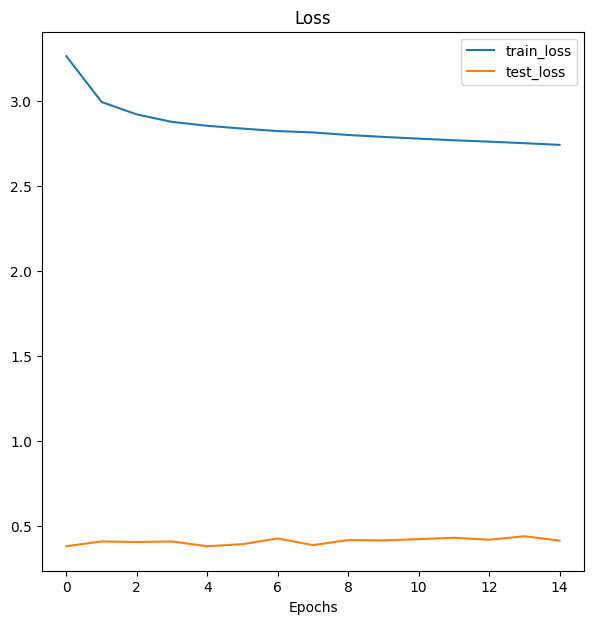

In [21]:
from timeit import default_timer as timer


optimizer = optim.Adam(model_lstm.parameters(), lr = learning_rate)

pad_idx = train_dataset.source_vocab.stoi['<PAD>']

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

accuracy = Accuracy("multiclass", num_classes=10000).to(device)

start_time = timer()

# train model_lstm
model_lstm_results = train(
    model=model_lstm,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    acc_fn=accuracy,
    epochs=num_epochs,
    device=device
)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
plot_loss_curves(model_lstm_results)


## loss VS. hyperparameter

### set 1

In [23]:
# Training hyperparameters SET 1
num_epochs = 15
learning_rate = 0.001
batch_size = 128

# Model hyperparameters
input_size_encoder = 10000
input_size_decoder = 10000
output_size = input_size_decoder
encoder_embedding_size = 16
decoder_embedding_size = 16
hidden_size = 16 
num_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5

transforms = False

train_loader = get_train_loader(train_dataset, batch_size, num_workers=4, shuffle=True, pin_memory=True)
test_loader = get_valid_loader(test_dataset, train_dataset, batch_size, num_workers=4, shuffle=True, pin_memory=True)

In [24]:
# define models, 1 for RNN and 2 for LSTM seq2seq
encoder_net_rnn = EncoderRNN(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net_rnn = DecoderRNN(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)

model_rnn = Seq2SeqRNN(encoder_net_rnn, decoder_net_rnn, output_size, device)
model_rnn.to(device)

encoder_net_lstm = EncoderLSTM(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net_lstm = DecoderLSTM(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)

model_lstm = Seq2SeqLSTM(encoder_net_lstm, decoder_net_lstm, output_size, device)
model_lstm.to(device)

Seq2SeqLSTM(
  (encoder): EncoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(10000, 16)
    (rnn): LSTM(16, 16, num_layers=2, dropout=0.5)
  )
  (decoder): DecoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(10000, 16)
    (rnn): LSTM(16, 16, num_layers=2, dropout=0.5)
    (fc): Linear(in_features=16, out_features=10000, bias=True)
  )
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.7436 | test_loss: 0.9477  
Epoch: 2 | train_loss: 3.1012 | test_loss: 0.4429  
Epoch: 3 | train_loss: 2.9991 | test_loss: 0.4214  
Epoch: 4 | train_loss: 2.9815 | test_loss: 0.4130  
Epoch: 5 | train_loss: 2.9731 | test_loss: 0.4135  
Epoch: 6 | train_loss: 2.9703 | test_loss: 0.3948  
Epoch: 7 | train_loss: 2.9653 | test_loss: 0.4060  
Epoch: 8 | train_loss: 2.9632 | test_loss: 0.3740  
Epoch: 9 | train_loss: 2.9618 | test_loss: 0.3904  
Epoch: 10 | train_loss: 2.9598 | test_loss: 0.3625  
Epoch: 11 | train_loss: 2.9559 | test_loss: 0.3549  
Epoch: 12 | train_loss: 2.9510 | test_loss: 0.3674  
Epoch: 13 | train_loss: 2.9476 | test_loss: 0.3538  
Epoch: 14 | train_loss: 2.9415 | test_loss: 0.3800  
Epoch: 15 | train_loss: 2.9352 | test_loss: 0.3622  
total training time: 51.527 sec.


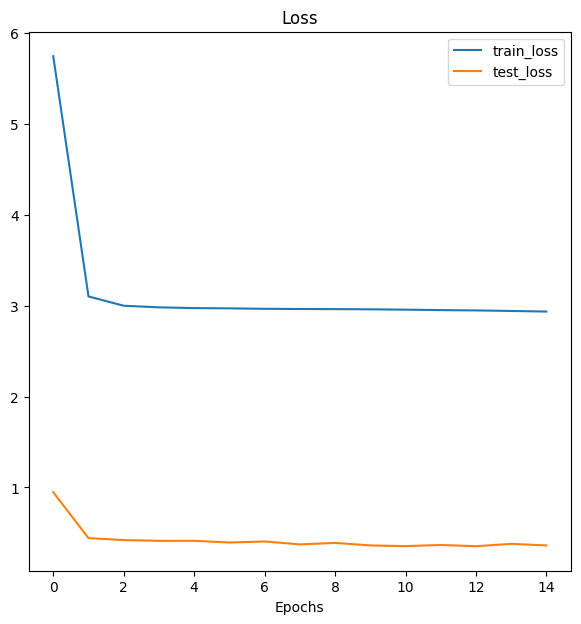

In [25]:
from timeit import default_timer as timer


optimizer = optim.Adam(model_rnn.parameters(), lr = learning_rate)

pad_idx = train_dataset.source_vocab.stoi['<PAD>']

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

accuracy = Accuracy("multiclass", num_classes=10000).to(device)

start_time = timer()

# train model_rnn
model_rnn_results = train(
    model=model_rnn,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    acc_fn=accuracy,
    epochs=num_epochs,
    device=device
)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
plot_loss_curves(model_rnn_results)


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.4574 | test_loss: 0.9642  
Epoch: 2 | train_loss: 3.2436 | test_loss: 0.6257  
Epoch: 3 | train_loss: 3.0697 | test_loss: 0.5017  
Epoch: 4 | train_loss: 3.0089 | test_loss: 0.4398  
Epoch: 5 | train_loss: 2.9851 | test_loss: 0.4136  
Epoch: 6 | train_loss: 2.9731 | test_loss: 0.4102  
Epoch: 7 | train_loss: 2.9669 | test_loss: 0.3736  
Epoch: 8 | train_loss: 2.9624 | test_loss: 0.3763  
Epoch: 9 | train_loss: 2.9584 | test_loss: 0.3604  
Epoch: 10 | train_loss: 2.9561 | test_loss: 0.3894  
Epoch: 11 | train_loss: 2.9517 | test_loss: 0.3612  
Epoch: 12 | train_loss: 2.9463 | test_loss: 0.3725  
Epoch: 13 | train_loss: 2.9410 | test_loss: 0.3810  
Epoch: 14 | train_loss: 2.9317 | test_loss: 0.3815  
Epoch: 15 | train_loss: 2.9155 | test_loss: 0.3862  
total training time: 51.167 sec.


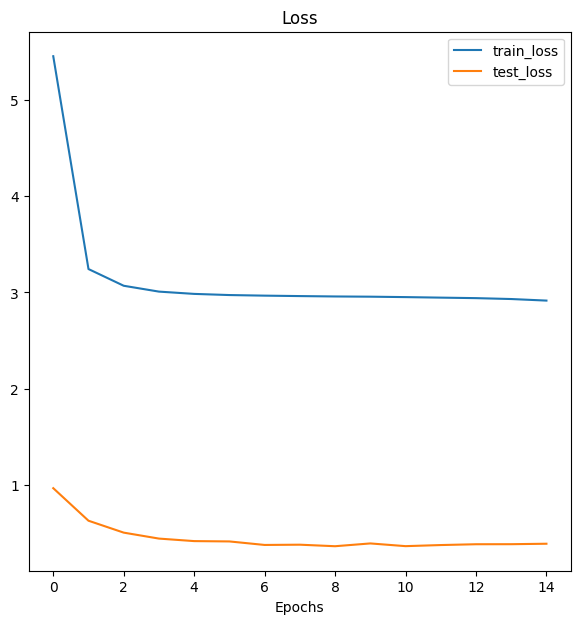

In [26]:
from timeit import default_timer as timer


optimizer = optim.Adam(model_lstm.parameters(), lr = learning_rate)

pad_idx = train_dataset.source_vocab.stoi['<PAD>']

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

accuracy = Accuracy("multiclass", num_classes=10000).to(device)

start_time = timer()

# train model_lstm
model_lstm_results = train(
    model=model_lstm,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    acc_fn=accuracy,
    epochs=num_epochs,
    device=device
)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
plot_loss_curves(model_lstm_results)


### set 2

In [27]:
# Training hyperparameters SET 2
num_epochs = 15
learning_rate = 0.001
batch_size = 128

# Model hyperparameters
input_size_encoder = 10000
input_size_decoder = 10000
output_size = input_size_decoder
encoder_embedding_size = 64
decoder_embedding_size = 64
hidden_size = 64
num_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5

transforms = False

train_loader = get_train_loader(train_dataset, batch_size, num_workers=4, shuffle=True, pin_memory=True)
test_loader = get_valid_loader(test_dataset, train_dataset, batch_size, num_workers=4, shuffle=True, pin_memory=True)

In [28]:
# define models, 1 for RNN and 2 for LSTM seq2seq
encoder_net_rnn = EncoderRNN(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net_rnn = DecoderRNN(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)

model_rnn = Seq2SeqRNN(encoder_net_rnn, decoder_net_rnn, output_size, device)
model_rnn.to(device)

encoder_net_lstm = EncoderLSTM(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net_lstm = DecoderLSTM(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)

model_lstm = Seq2SeqLSTM(encoder_net_lstm, decoder_net_lstm, output_size, device)
model_lstm.to(device)

Seq2SeqLSTM(
  (encoder): EncoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(10000, 64)
    (rnn): LSTM(64, 64, num_layers=2, dropout=0.5)
  )
  (decoder): DecoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(10000, 64)
    (rnn): LSTM(64, 64, num_layers=2, dropout=0.5)
    (fc): Linear(in_features=64, out_features=10000, bias=True)
  )
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.5731 | test_loss: 0.3836  
Epoch: 2 | train_loss: 3.0083 | test_loss: 0.4019  
Epoch: 3 | train_loss: 2.9640 | test_loss: 0.3699  
Epoch: 4 | train_loss: 2.9188 | test_loss: 0.3380  
Epoch: 5 | train_loss: 2.8946 | test_loss: 0.3370  
Epoch: 6 | train_loss: 2.8820 | test_loss: 0.3907  
Epoch: 7 | train_loss: 2.8716 | test_loss: 0.4259  
Epoch: 8 | train_loss: 2.8626 | test_loss: 0.3960  
Epoch: 9 | train_loss: 2.8556 | test_loss: 0.4262  
Epoch: 10 | train_loss: 2.8476 | test_loss: 0.4004  
Epoch: 11 | train_loss: 2.8405 | test_loss: 0.3264  
Epoch: 12 | train_loss: 2.8341 | test_loss: 0.4419  
Epoch: 13 | train_loss: 2.8276 | test_loss: 0.3592  
Epoch: 14 | train_loss: 2.8211 | test_loss: 0.3893  
Epoch: 15 | train_loss: 2.8145 | test_loss: 0.3891  
total training time: 53.853 sec.


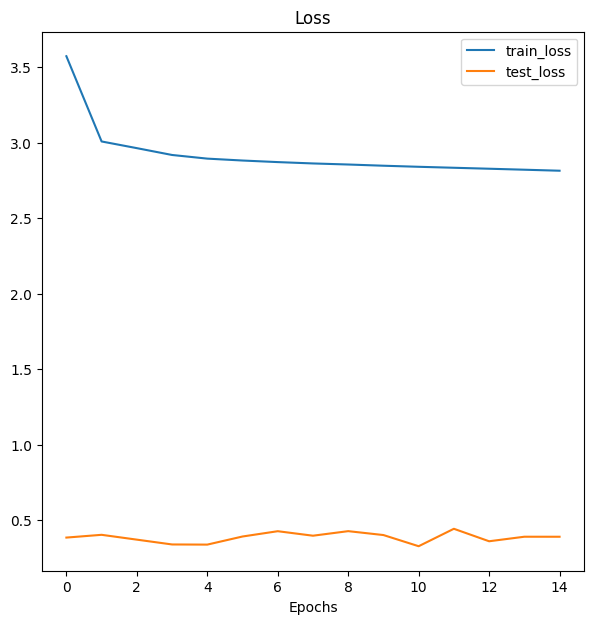

In [29]:
from timeit import default_timer as timer


optimizer = optim.Adam(model_rnn.parameters(), lr = learning_rate)

pad_idx = train_dataset.source_vocab.stoi['<PAD>']

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

accuracy = Accuracy("multiclass", num_classes=10000).to(device)

start_time = timer()

# train model_rnn
model_rnn_results = train(
    model=model_rnn,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    acc_fn=accuracy,
    epochs=num_epochs,
    device=device
)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
plot_loss_curves(model_rnn_results)


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.7537 | test_loss: 0.4228  
Epoch: 2 | train_loss: 2.9919 | test_loss: 0.3294  
Epoch: 3 | train_loss: 2.9727 | test_loss: 0.3506  
Epoch: 4 | train_loss: 2.9533 | test_loss: 0.3348  
Epoch: 5 | train_loss: 2.9212 | test_loss: 0.4346  
Epoch: 6 | train_loss: 2.8911 | test_loss: 0.3937  
Epoch: 7 | train_loss: 2.8661 | test_loss: 0.3876  
Epoch: 8 | train_loss: 2.8469 | test_loss: 0.3717  
Epoch: 9 | train_loss: 2.8345 | test_loss: 0.4030  
Epoch: 10 | train_loss: 2.8236 | test_loss: 0.4443  
Epoch: 11 | train_loss: 2.8146 | test_loss: 0.3974  
Epoch: 12 | train_loss: 2.8073 | test_loss: 0.4029  
Epoch: 13 | train_loss: 2.7984 | test_loss: 0.3969  
Epoch: 14 | train_loss: 2.7928 | test_loss: 0.4140  
Epoch: 15 | train_loss: 2.7848 | test_loss: 0.3949  
total training time: 51.084 sec.


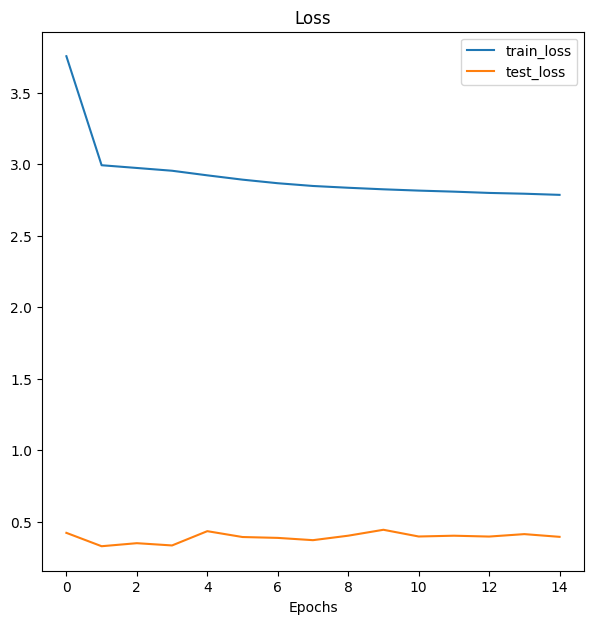

In [30]:
from timeit import default_timer as timer


optimizer = optim.Adam(model_lstm.parameters(), lr = learning_rate)

pad_idx = train_dataset.source_vocab.stoi['<PAD>']

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

accuracy = Accuracy("multiclass", num_classes=10000).to(device)

start_time = timer()

# train model_lstm
model_lstm_results = train(
    model=model_lstm,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    acc_fn=accuracy,
    epochs=num_epochs,
    device=device
)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
plot_loss_curves(model_lstm_results)


### set 3

In [31]:
# Training hyperparameters SET 3
num_epochs = 15
learning_rate = 0.001
batch_size = 128

# Model hyperparameters
input_size_encoder = 10000
input_size_decoder = 10000
output_size = input_size_decoder
encoder_embedding_size = 16
decoder_embedding_size = 16
hidden_size = 16 
num_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5

transforms = False

train_loader = get_train_loader(train_dataset, batch_size, num_workers=4, shuffle=True, pin_memory=True)
test_loader = get_valid_loader(test_dataset, train_dataset, batch_size, num_workers=4, shuffle=True, pin_memory=True)

In [32]:
# define models, 1 for RNN and 2 for LSTM seq2seq
encoder_net_rnn = EncoderRNN(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net_rnn = DecoderRNN(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)

model_rnn = Seq2SeqRNN(encoder_net_rnn, decoder_net_rnn, output_size, device)
model_rnn.to(device)

encoder_net_lstm = EncoderLSTM(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net_lstm = DecoderLSTM(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)

model_lstm = Seq2SeqLSTM(encoder_net_lstm, decoder_net_lstm, output_size, device)
model_lstm.to(device)

Seq2SeqLSTM(
  (encoder): EncoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(10000, 16)
    (rnn): LSTM(16, 16, num_layers=2, dropout=0.5)
  )
  (decoder): DecoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(10000, 16)
    (rnn): LSTM(16, 16, num_layers=2, dropout=0.5)
    (fc): Linear(in_features=16, out_features=10000, bias=True)
  )
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.4844 | test_loss: 0.8479  
Epoch: 2 | train_loss: 3.0879 | test_loss: 0.4479  
Epoch: 3 | train_loss: 2.9970 | test_loss: 0.4199  
Epoch: 4 | train_loss: 2.9801 | test_loss: 0.4140  
Epoch: 5 | train_loss: 2.9726 | test_loss: 0.4114  
Epoch: 6 | train_loss: 2.9698 | test_loss: 0.4090  
Epoch: 7 | train_loss: 2.9663 | test_loss: 0.3880  
Epoch: 8 | train_loss: 2.9639 | test_loss: 0.3787  
Epoch: 9 | train_loss: 2.9605 | test_loss: 0.3757  
Epoch: 10 | train_loss: 2.9579 | test_loss: 0.3542  
Epoch: 11 | train_loss: 2.9524 | test_loss: 0.3643  
Epoch: 12 | train_loss: 2.9450 | test_loss: 0.3788  
Epoch: 13 | train_loss: 2.9335 | test_loss: 0.3714  
Epoch: 14 | train_loss: 2.9236 | test_loss: 0.3514  
Epoch: 15 | train_loss: 2.9132 | test_loss: 0.3752  
total training time: 51.219 sec.


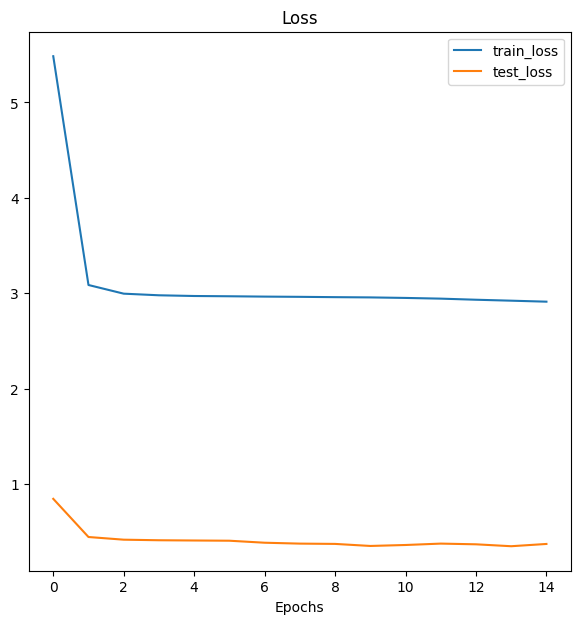

In [33]:
from timeit import default_timer as timer


optimizer = optim.Adam(model_rnn.parameters(), lr = learning_rate)

pad_idx = train_dataset.source_vocab.stoi['<PAD>']

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

accuracy = Accuracy("multiclass", num_classes=10000).to(device)

start_time = timer()

# train model_rnn
model_rnn_results = train(
    model=model_rnn,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    acc_fn=accuracy,
    epochs=num_epochs,
    device=device
)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
plot_loss_curves(model_rnn_results)


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.4872 | test_loss: 1.1808  
Epoch: 2 | train_loss: 3.4217 | test_loss: 0.7925  
Epoch: 3 | train_loss: 3.1243 | test_loss: 0.4905  
Epoch: 4 | train_loss: 3.0204 | test_loss: 0.4270  
Epoch: 5 | train_loss: 2.9893 | test_loss: 0.4076  
Epoch: 6 | train_loss: 2.9761 | test_loss: 0.3475  
Epoch: 7 | train_loss: 2.9686 | test_loss: 0.3455  
Epoch: 8 | train_loss: 2.9632 | test_loss: 0.3868  
Epoch: 9 | train_loss: 2.9560 | test_loss: 0.3844  
Epoch: 10 | train_loss: 2.9498 | test_loss: 0.4097  
Epoch: 11 | train_loss: 2.9365 | test_loss: 0.3939  
Epoch: 12 | train_loss: 2.9205 | test_loss: 0.3870  
Epoch: 13 | train_loss: 2.9004 | test_loss: 0.4054  
Epoch: 14 | train_loss: 2.8840 | test_loss: 0.3836  
Epoch: 15 | train_loss: 2.8704 | test_loss: 0.4002  
total training time: 52.006 sec.


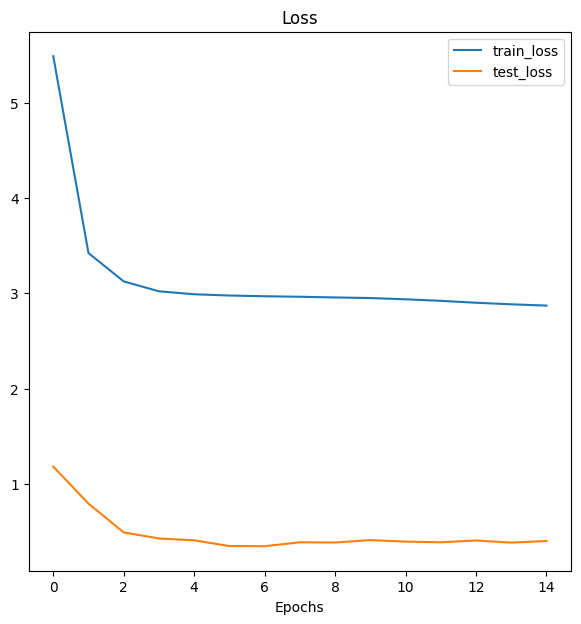

In [34]:
from timeit import default_timer as timer


optimizer = optim.Adam(model_lstm.parameters(), lr = learning_rate)

pad_idx = train_dataset.source_vocab.stoi['<PAD>']

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

accuracy = Accuracy("multiclass", num_classes=10000).to(device)

start_time = timer()

# train model_lstm
model_lstm_results = train(
    model=model_lstm,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    acc_fn=accuracy,
    epochs=num_epochs,
    device=device
)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
plot_loss_curves(model_lstm_results)


### set 4

In [35]:
# Training hyperparameters SET 4
num_epochs = 15
learning_rate = 0.001
batch_size = 128

# Model hyperparameters
input_size_encoder = 10000
input_size_decoder = 10000
output_size = input_size_decoder
encoder_embedding_size = 64
decoder_embedding_size = 64
hidden_size = 64
num_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5

transforms = False

train_loader = get_train_loader(train_dataset, batch_size, num_workers=4, shuffle=True, pin_memory=True)
test_loader = get_valid_loader(test_dataset, train_dataset, batch_size, num_workers=4, shuffle=True, pin_memory=True)

In [36]:
# define models, 1 for RNN and 2 for LSTM seq2seq
encoder_net_rnn = EncoderRNN(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net_rnn = DecoderRNN(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)

model_rnn = Seq2SeqRNN(encoder_net_rnn, decoder_net_rnn, output_size, device)
model_rnn.to(device)

encoder_net_lstm = EncoderLSTM(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net_lstm = DecoderLSTM(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)

model_lstm = Seq2SeqLSTM(encoder_net_lstm, decoder_net_lstm, output_size, device)
model_lstm.to(device)

Seq2SeqLSTM(
  (encoder): EncoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(10000, 64)
    (rnn): LSTM(64, 64, num_layers=2, dropout=0.5)
  )
  (decoder): DecoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(10000, 64)
    (rnn): LSTM(64, 64, num_layers=2, dropout=0.5)
    (fc): Linear(in_features=64, out_features=10000, bias=True)
  )
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6072 | test_loss: 0.4224  
Epoch: 2 | train_loss: 3.0086 | test_loss: 0.3275  
Epoch: 3 | train_loss: 2.9737 | test_loss: 0.3975  
Epoch: 4 | train_loss: 2.9253 | test_loss: 0.3352  
Epoch: 5 | train_loss: 2.8985 | test_loss: 0.3402  
Epoch: 6 | train_loss: 2.8848 | test_loss: 0.3325  
Epoch: 7 | train_loss: 2.8743 | test_loss: 0.3618  
Epoch: 8 | train_loss: 2.8643 | test_loss: 0.3344  
Epoch: 9 | train_loss: 2.8574 | test_loss: 0.3950  
Epoch: 10 | train_loss: 2.8498 | test_loss: 0.3455  
Epoch: 11 | train_loss: 2.8421 | test_loss: 0.3906  
Epoch: 12 | train_loss: 2.8353 | test_loss: 0.3863  
Epoch: 13 | train_loss: 2.8287 | test_loss: 0.3610  
Epoch: 14 | train_loss: 2.8245 | test_loss: 0.3763  
Epoch: 15 | train_loss: 2.8161 | test_loss: 0.4744  
total training time: 51.485 sec.


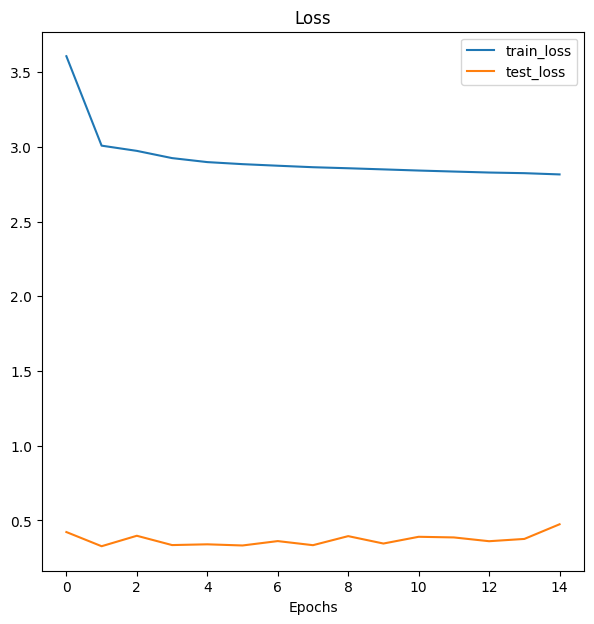

In [37]:
from timeit import default_timer as timer


optimizer = optim.Adam(model_rnn.parameters(), lr = learning_rate)

pad_idx = train_dataset.source_vocab.stoi['<PAD>']

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

accuracy = Accuracy("multiclass", num_classes=10000).to(device)

start_time = timer()

# train model_rnn
model_rnn_results = train(
    model=model_rnn,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    acc_fn=accuracy,
    epochs=num_epochs,
    device=device
)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
plot_loss_curves(model_rnn_results)


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.7686 | test_loss: 0.4565  
Epoch: 2 | train_loss: 2.9945 | test_loss: 0.3852  
Epoch: 3 | train_loss: 2.9759 | test_loss: 0.3902  
Epoch: 4 | train_loss: 2.9694 | test_loss: 0.3963  
Epoch: 5 | train_loss: 2.9601 | test_loss: 0.3480  
Epoch: 6 | train_loss: 2.9417 | test_loss: 0.4318  
Epoch: 7 | train_loss: 2.9102 | test_loss: 0.3817  
Epoch: 8 | train_loss: 2.8796 | test_loss: 0.4057  
Epoch: 9 | train_loss: 2.8580 | test_loss: 0.4016  
Epoch: 10 | train_loss: 2.8418 | test_loss: 0.3962  
Epoch: 11 | train_loss: 2.8295 | test_loss: 0.3644  
Epoch: 12 | train_loss: 2.8190 | test_loss: 0.3580  
Epoch: 13 | train_loss: 2.8116 | test_loss: 0.4201  
Epoch: 14 | train_loss: 2.8028 | test_loss: 0.4071  
Epoch: 15 | train_loss: 2.7974 | test_loss: 0.3839  
total training time: 52.529 sec.


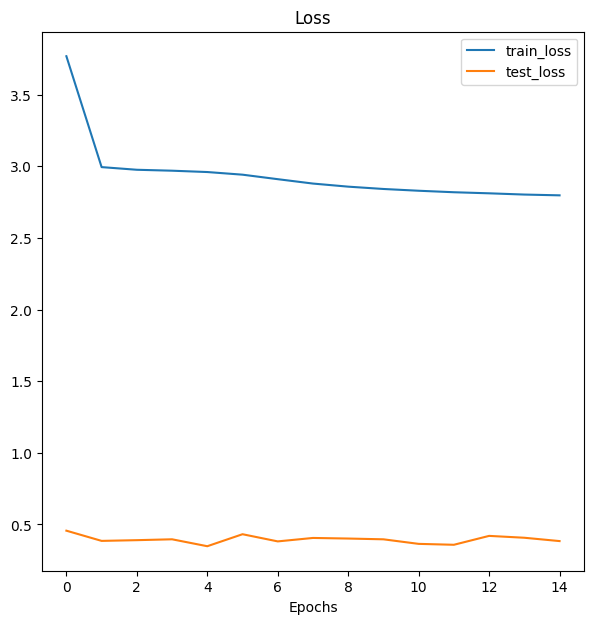

In [38]:
from timeit import default_timer as timer


optimizer = optim.Adam(model_lstm.parameters(), lr = learning_rate)

pad_idx = train_dataset.source_vocab.stoi['<PAD>']

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

accuracy = Accuracy("multiclass", num_classes=10000).to(device)

start_time = timer()

# train model_lstm
model_lstm_results = train(
    model=model_lstm,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    acc_fn=accuracy,
    epochs=num_epochs,
    device=device
)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
plot_loss_curves(model_lstm_results)


## Adding Attention

### RNN with atttention

In [40]:
import random
class EncoderRNNAttention(nn.Module):
    """
    ### Define EncoderRNN
    The input to encoder is the whole sentence. Therefore, the size of x in forward is (seq_length, batch_size)
    """
    '''
    input_size -> source vocab size
    '''
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout_p):
        super(EncoderRNNAttention, self).__init__()
        self.dropout = nn.Dropout(dropout_p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, dropout=dropout_p)
        
    def forward(self, x):
        # print("Inside encoder forward")
        # shape of x-> (seq_length, batch_size)
        embedding = self.dropout(self.embedding(x)) #shape-> (seq_length, batch_size, embedding_size)
        # print(f"embedding shape: {embedding.shape}")
        outputs, (hidden,cell) = self.rnn(embedding)
        # print('output: ', outputs.shape, '\nhidden: ', hidden.shape)
        return hidden, cell #shape-> (num_layers, batch_size, hidden_size)


class DecoderRNNAttention(nn.Module):
    """
    ### Define DecoderRNN
    * Input is one word at a time. shape of x is-> (1, batch_size)
    * embedding size-> (1, batch_size, embedding_size)
    * outputs-> (1, batch_size, hidden_size)
    * predictions -> (batch_size, output_size)
    """
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, dropout_p):
        super(DecoderRNNAttention, self).__init__()
        self.dropout = nn.Dropout(dropout_p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, dropout = dropout_p)
        
        self.attention = nn.Linear(hidden_size + embedding_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden, cell, encoder_outputs):
        # x -> (batch_size,)
        # hidden, cell -> (num_layers, batch_size, hidden_size)
        # encoder_outputs -> (src_seq_len, batch_size, hidden_size)
        x = x.unsqueeze(0)  # x -> (1, batch_size)
        embedding = self.dropout(self.embedding(x))  # embedding -> (1, batch_size, embedding_size)
        
        attn_input = torch.cat((embedding, hidden[-1].unsqueeze(0)), dim=2) # attn_input -> (1, batch_size, embedding_size + hidden_size)
        attn_weights = F.softmax(self.attention(attn_input), dim=2) # attn_weights -> (1, batch_size, seq_length)
        
        # Apply attention to encoder_outputs
        context = torch.bmm(attn_weights.transpose(0,1), encoder_outputs.transpose(0,1)) # context -> (batch_size, 1, hidden_size)
        context = context.transpose(0,1) # context -> (1, batch_size, hidden_size)
        
        # rnn_input -> (1, batch_size, embedding_size + hidden_size)
        rnn_input = torch.cat((embedding, context), dim=2)
        
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))  # output -> (1, batch_size, hidden_size)
        prediction = self.output(output.squeeze(0))  # prediction -> (batch_size, output_size)
        return prediction, hidden, cell, attn_weights.squeeze(0)
    

class Seq2SeqRNNAttention(nn.Module):
    def __init__(self, encoder, decoder, output_size, device):
        super(Seq2SeqRNNAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.output_size = output_size
        self.device = device
        
    def forward(self, source , target, teacher_force_ratio = 0.5):
        #source-> (max_seq_length, batch_size)
        #target-> (max_seq_length, batch_size)
        batch_size = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = self.output_size #the size of target vocab
        
        #this tensor will be used for predicting output one by one
        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)
        
        hidden, cell = self.encoder(source)
        
        #get first token from input to the decoder -> <SOS>
        x = target[0] #shape -> (,batch_size)
        
        for t in range(1, target_len):
            #get output, hidden, cell from decoder. Input is x, previous hidden and cell
            prediction, hidden, cell = self.decoder(x, hidden, cell)
            #prediction shape-> (batch_size, target_vocab_size)
            
            #store next output prediction
            outputs[t] = prediction
            
            #get best word the decoder predicted (index of target_vocab)
            best_guess = prediction.argmax(1)
            #print('best guess: ', best_guess.shape)
            #print('target[t]: ', target[t].shape)
            # teacher forcing ratio is used to sometime input the previous prediction and sometime give the actual word from training data
            x = target[t] if random.random()<teacher_force_ratio else best_guess
            
            
        return outputs #shape-> (seq_length, batch_size, target_vocab)


### LSTM with attention

In [45]:
import random

class EncoderLSTMAttention(nn.Module):
    """
    ### Define EncoderLSTMAttention
    The input to encoder is the whole sentence. Therefore, the size of x in forward is (seq_length, batch_size)
    """
    '''
    input_size -> source vocab size
    '''
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout_p):
        super(EncoderLSTMAttention, self).__init__()
        self.dropout = nn.Dropout(dropout_p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout_p)
        
    def forward(self, x):
        # shape of x-> (seq_length, batch_size)
        embedding = self.dropout(self.embedding(x)) #shape-> (seq_length, batch_size, embedding_size)
        
        outputs, (hidden,cell) = self.rnn(embedding)
        
        return hidden, cell #shape-> (num_layers, batch_size, hidden_size)



class DecoderLSTMAttention(nn.Module):
    """
    ### Define DecoderLSTMAttention
    * Input is one word at a time. shape of x is-> (1, batch_size)
    * embedding size-> (1, batch_size, embedding_size)
    * outputs-> (1, batch_size, hidden_size)
    * predictions -> (batch_size, output_size)
    """
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, dropout_p):
        super(DecoderLSTMAttention, self).__init__()
        self.dropout = nn.Dropout(dropout_p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout_p)
        self.fc = nn.Linear(hidden_size, output_size)
        self.attn = nn.Linear(hidden_size + hidden_size, hidden_size) # Attention mechanism

    def forward(self, x, hidden, cell, encoder_outputs):
        # for next(iter(train_loader))[1][0] will give us the first word for batch_size (,batch_size)
        # to input to model, we need to add a dimension at 0
        # x-> (, batch_size) -> convert to (1, batch_size)
        x = x.unsqueeze(0)
        embedding = self.dropout(self.embedding(x)) #(1, batch_size, embedding_size)
        output, (hidden, cell) = self.rnn(embedding, (hidden, cell))
        # outputshape -> (1, batch_size, hidden_size)
        # encoder_outputs -> (seq_len, batch_size, hidden_size)
        attn_weights = torch.bmm(output.permute(1, 0, 2), encoder_outputs.permute(1, 2, 0)) # attention weights
        # attn_weights -> (batch_size, 1, seq_len)
        attn_weights = torch.softmax(attn_weights, dim=2) # softmax to get attention distribution
        context = torch.bmm(attn_weights, encoder_outputs.permute(1, 0, 2)) # context vector
        # context -> (batch_size, 1, hidden_size)
        output = torch.tanh(self.attn(torch.cat((context, output), dim=2))) # concatenate context and output, and pass through linear layer
        predictions = self.fc(output) #(1, batch_size, output_size)
        predictions = predictions.squeeze(0) #(batch_size, output_size)
        return predictions, hidden, cell
    


class Seq2SeqLSTMAttention(nn.Module):
    def __init__(self, encoder, decoder, output_size, device):
        super(Seq2SeqLSTMAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.output_size = output_size
        self.device = device
        
    def forward(self, source , target, teacher_force_ratio = 0.5):
        #source-> (max_seq_length, batch_size)
        #target-> (max_seq_length, batch_size)
        batch_size = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = self.output_size #the size of target vocab
        
        #this tensor will be used for predicting output one by one
        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)
        
        hidden, cell = self.encoder(source)
        
        #get first token from input to the decoder -> <SOS>
        x = target[0] #shape -> (,batch_size)
        
        for t in range(1, target_len):
            #get output, hidden, cell from decoder. Input is x, previous hidden and cell
            prediction, hidden, cell = self.decoder(x, hidden, cell)
            #prediction shape-> (batch_size, target_vocab_size)
            
            #store next output prediction
            outputs[t] = prediction
            
            #get best word the decoder predicted (index of target_vocab)
            best_guess = prediction.argmax(1)
            #print('best guess: ', best_guess.shape)
            #print('target[t]: ', target[t].shape)
            # teacher forcing ratio is used to sometime input the previous prediction and sometime give the actual word from training data
            x = target[t] if random.random()<teacher_force_ratio else best_guess
            
            
        return outputs #shape-> (seq_length, batch_size, target_vocab)


### Training the models

In [46]:
# Training hyperparameters SET 3
num_epochs = 15
learning_rate = 0.001
batch_size = 128

# Model hyperparameters
input_size_encoder = 10000
input_size_decoder = 10000
output_size = input_size_decoder
encoder_embedding_size = 16
decoder_embedding_size = 16
hidden_size = 16 
num_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5

transforms = False

train_loader = get_train_loader(train_dataset, batch_size, num_workers=4, shuffle=True, pin_memory=True)
test_loader = get_valid_loader(test_dataset, train_dataset, batch_size, num_workers=4, shuffle=True, pin_memory=True)

In [47]:
# define models, 1 for RNN and 2 for LSTM seq2seq
encoder_net_rnn_attention = EncoderRNNAttention(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net_rnn_attention = DecoderRNNAttention(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)

model_rnn_attention = Seq2SeqRNNAttention(encoder_net_rnn, decoder_net_rnn, output_size, device)
model_rnn_attention.to(device)

encoder_net_lstm_attention = EncoderLSTMAttention(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net_lstm_attention = DecoderLSTMAttention(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)

model_lstm_attention = Seq2SeqLSTMAttention(encoder_net_lstm, decoder_net_lstm, output_size, device)
model_lstm_attention.to(device)

Seq2SeqLSTMAttention(
  (encoder): EncoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(10000, 16)
    (rnn): LSTM(16, 16, num_layers=2, dropout=0.5)
  )
  (decoder): DecoderLSTM(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(10000, 16)
    (rnn): LSTM(16, 16, num_layers=2, dropout=0.5)
    (fc): Linear(in_features=16, out_features=10000, bias=True)
  )
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9662 | test_loss: 0.3928  
Epoch: 2 | train_loss: 2.8656 | test_loss: 0.4266  
Epoch: 3 | train_loss: 2.8344 | test_loss: 0.4217  
Epoch: 4 | train_loss: 2.8210 | test_loss: 0.3460  
Epoch: 5 | train_loss: 2.8082 | test_loss: 0.3446  
Epoch: 6 | train_loss: 2.8008 | test_loss: 0.3746  
Epoch: 7 | train_loss: 2.7924 | test_loss: 0.3948  
Epoch: 8 | train_loss: 2.7862 | test_loss: 0.4605  
Epoch: 9 | train_loss: 2.7811 | test_loss: 0.4337  
Epoch: 10 | train_loss: 2.7753 | test_loss: 0.4036  
Epoch: 11 | train_loss: 2.7698 | test_loss: 0.3907  
Epoch: 12 | train_loss: 2.7634 | test_loss: 0.4242  
Epoch: 13 | train_loss: 2.7591 | test_loss: 0.4343  
Epoch: 14 | train_loss: 2.7528 | test_loss: 0.4265  
Epoch: 15 | train_loss: 2.7493 | test_loss: 0.3853  
total training time: 52.341 sec.


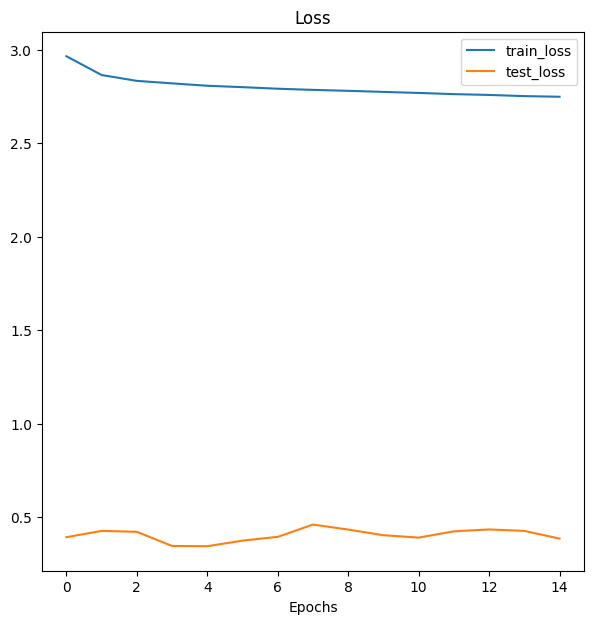

In [43]:
from timeit import default_timer as timer


optimizer = optim.Adam(model_rnn_attention.parameters(), lr = learning_rate)

pad_idx = train_dataset.source_vocab.stoi['<PAD>']

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

accuracy = Accuracy("multiclass", num_classes=10000).to(device)

start_time = timer()

# train model_rnn_attention
model_rnn_attention_results = train(
    model=model_rnn_attention,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    acc_fn=accuracy,
    epochs=num_epochs,
    device=device
)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
plot_loss_curves(model_rnn_attention_results)


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.4217 | test_loss: 0.8201  
Epoch: 2 | train_loss: 3.1732 | test_loss: 0.4917  
Epoch: 3 | train_loss: 3.0293 | test_loss: 0.4179  
Epoch: 4 | train_loss: 2.9920 | test_loss: 0.4130  
Epoch: 5 | train_loss: 2.9764 | test_loss: 0.3694  
Epoch: 6 | train_loss: 2.9659 | test_loss: 0.3848  
Epoch: 7 | train_loss: 2.9620 | test_loss: 0.3848  
Epoch: 8 | train_loss: 2.9571 | test_loss: 0.3803  
Epoch: 9 | train_loss: 2.9532 | test_loss: 0.3886  
Epoch: 10 | train_loss: 2.9493 | test_loss: 0.3529  
Epoch: 11 | train_loss: 2.9495 | test_loss: 0.3472  
Epoch: 12 | train_loss: 2.9457 | test_loss: 0.3649  
Epoch: 13 | train_loss: 2.9402 | test_loss: 0.3601  
Epoch: 14 | train_loss: 2.9278 | test_loss: 0.3655  
Epoch: 15 | train_loss: 2.9105 | test_loss: 0.3848  
total training time: 51.066 sec.


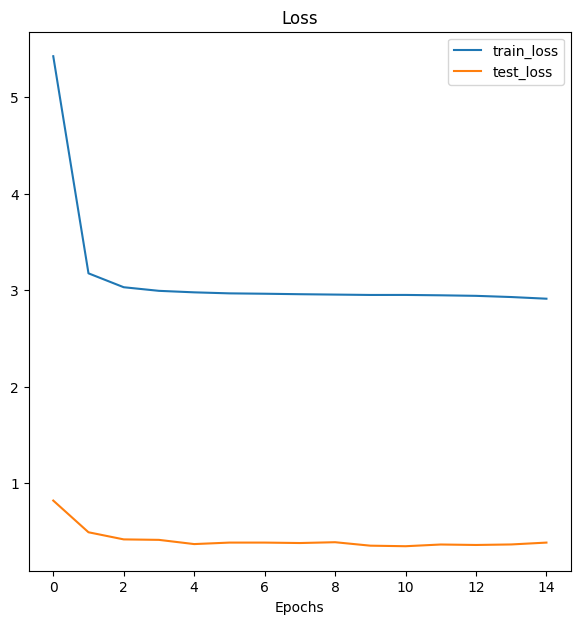

In [48]:
from timeit import default_timer as timer


optimizer = optim.Adam(model_lstm_attention.parameters(), lr = learning_rate)

pad_idx = train_dataset.source_vocab.stoi['<PAD>']

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

accuracy = Accuracy("multiclass", num_classes=10000).to(device)

start_time = timer()

# train model_lstm_attention
model_lstm_attention_results = train(
    model=model_lstm_attention,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    acc_fn=accuracy,
    epochs=num_epochs,
    device=device
)

# end timer
end_time = timer()
# printing time taken
print(f"total training time: {end_time-start_time:.3f} sec.")
plot_loss_curves(model_lstm_attention_results)
